In [15]:
import os
import numpy as np
import json

def extract_first_16_frames(filepath, label):
    """
    JSON 파일에서 첫 16 프레임을 추출하고, view1~view5의 랜드마크 데이터를 포함합니다.
    Waist 좌표를 기준으로 상대 좌표로 변환합니다.
    """
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        
        # frames 데이터 확인
        frames = data['frames']
        if len(frames) < 16:
            print(f"프레임 개수 부족: {filepath}, 프레임 개수: {len(frames)}")
            return None  # 프레임 개수가 16 미만인 데이터는 제외

        # 첫 16프레임 추출
        first_16_frames = frames[:16]

        # view1~view5의 랜드마크 좌표 추출
        extracted_data = []
        for frame in first_16_frames:
            frame_data = []
            
            # Waist 좌표 가져오기
            waist_coords = frame.get('view1', {}).get('pts', {}).get('Waist', {})
            if not waist_coords:
                print(f"Waist 좌표 없음: {filepath}")
                return None  # Waist 좌표가 없는 경우 제외
            
            waist_x = waist_coords['x']
            waist_y = waist_coords['y']
            
            for view in ['view1', 'view2', 'view3', 'view4', 'view5']:
                view_data = frame.get(view, {}).get('pts', {})
                if not view_data:
                    print(f"{view} 데이터 없음: {filepath}")
                    return None  # 특정 view 데이터가 없는 경우 제외
                
                # (x, y) 좌표 추출 및 상대 좌표로 변환
                coords = []
                for point in view_data.values():
                    relative_x = point['x'] - waist_x  # Waist 기준 상대 x 좌표
                    relative_y = point['y'] - waist_y  # Waist 기준 상대 y 좌표
                    coords.append((relative_x, relative_y))
                frame_data.append(coords)
            extracted_data.append(frame_data)
        
        # NumPy 배열로 변환 (16, 5, 24, 2) 형태
        return np.array(extracted_data), label

    except Exception as e:
        print(f"에러 발생: {e}")
        return None

def determine_label(filename):
    """
    파일 이름에 따라 라벨을 결정합니다.
    """
    try:
        # 파일 이름에서 숫자 부분 추출 (예: D19-1-697.json -> 697)
        suffix = int(filename.split('-')[-1].split('.')[0])
        if 697 <= suffix <= 712:
            return 0  # 클래스 0
        elif 713 <= suffix <= 728:
            return 1  # 클래스 1
        elif 561 <= suffix <= 592:
            return 2  # 클래스 2
        elif 313 <= suffix <= 328:
            return 3  # 클래스 3
        elif 281 <= suffix <= 312:
            return 4  # 클래스 4
        elif 377 <= suffix <= 408:
            return 5  # 클래스 5
        elif 409 <= suffix <= 472:
            return 6  # 클래스 6
        else:
            return None  # 라벨을 지정할 수 없는 경우
    except Exception as e:
        print(f"라벨 결정 중 오류 발생: {filename}, 오류: {e}")
        return None

# 베이스 경로 설정
base_path = '/home/hyun/dev_ws/MLDL_project/training_data/'

processed_data = []
labels = []

try:
    for filename in os.listdir(base_path):
        if filename.endswith('.json') and '-3d' not in filename:
            filepath = os.path.join(base_path, filename)
            label = determine_label(filename)
            if label is not None:
                result = extract_first_16_frames(filepath, label)
                if result is not None:
                    data, lbl = result
                    # 각 view 데이터를 독립적인 시퀀스로 처리
                    for view_index in range(5):  # 5개의 뷰 처리
                        view_data = data[:, view_index, :, :]  # (16, 24, 2)
                        processed_data.append(view_data)
                        labels.append(lbl)
except FileNotFoundError as e:
    print(f"디렉토리 오류: {e}")
except Exception as e:
    print(f"알 수 없는 오류: {e}")

# 결과 확인
print(f"총 처리된 데이터 수: {len(processed_data)}")
if processed_data:
    processed_data_array = np.array(processed_data)  # (전체 데이터 수, 16, 24, 2)
    print(f"변환된 데이터 shape: {processed_data_array.shape}")
    print(f"전체 라벨 개수: {len(labels)}")
    print(f"샘플 데이터 shape: {processed_data_array[0].shape}")
    print(f"샘플 데이터 라벨: {labels[0]}")

# 데이터 저장
save_path = '/home/hyun/processed_data_views5.npy'
np.save(save_path, processed_data_array)

label_save_path = '/home/hyun/labels_views5.npy'
np.save(label_save_path, np.array(labels))

print(f"데이터가 저장되었습니다: {save_path}")
print(f"라벨이 저장되었습니다: {label_save_path}")


프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D11-8-312.json, 프레임 개수: 14
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D04-4-424.json, 프레임 개수: 15
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D04-4-409.json, 프레임 개수: 15
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D11-3-312.json, 프레임 개수: 10
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D11-7-312.json, 프레임 개수: 10
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D11-1-311.json, 프레임 개수: 14
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D16-9-402.json, 프레임 개수: 0
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D11-6-312.json, 프레임 개수: 14
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D11-5-312.json, 프레임 개수: 14
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D11-9-320.json, 프레임 개수: 15
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D15-4-305.json, 프레임 개수: 0
프레임 개수 부족: /home/hyun/dev_ws/MLDL_project/training_data/D11-1-328.json, 프레임 개수: 9
프레임 개수 

In [1]:
import numpy as np

# 데이터 로드
data_path = '/home/hyun/processed_data_views5.npy'
label_path = '/home/hyun/labels_views5.npy'

X = np.load(data_path)
y = np.load(label_path) 

print(f"입력 데이터 shape: {X.shape}")
print(f"라벨 데이터 shape: {y.shape}")


입력 데이터 shape: (41715, 16, 24, 2)
라벨 데이터 shape: (41715,)


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Conv2D, TimeDistributed, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, TimeDistributed, GRU, Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# 데이터 로드
data_path = '/home/hyun/processed_data_views5.npy'
label_path = '/home/hyun/labels_views5.npy'

X = np.load(data_path) 
y = np.load(label_path)  

print(f"입력 데이터 shape: {X.shape}")
print(f"라벨 데이터 shape: {y.shape}")

# 라벨을 원-핫 인코딩으로 변환
y = to_categorical(y, num_classes=7) 

# 데이터 분할 (70% 학습, 15% 검증, 15% 테스트)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"학습 데이터: {X_train.shape}, {y_train.shape}")
print(f"검증 데이터: {X_val.shape}, {y_val.shape}")
print(f"테스트 데이터: {X_test.shape}, {y_test.shape}")

# 모델 설계 (GRU 사용, L2 정규화 추가, 배치 정규화 추가)
model = Sequential([
    TimeDistributed(Conv1D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.03)), input_shape=(16, 24, 2)),
    TimeDistributed(Flatten()),  # Conv1D 결과를 펼침
    GRU(128, return_sequences=True, kernel_regularizer=l2(0.03)),
    Dropout(0.5),
    GRU(64, return_sequences=False, kernel_regularizer=l2(0.03)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


# 학습률을 낮춘 Adam 옵티마이저 사용
optimizer = Adam(learning_rate=0.0001)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()

# EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=4,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],  # EarlyStopping 콜백 추가
    verbose=1
)

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"테스트 손실: {test_loss}")
print(f"테스트 정확도: {test_acc}")

# 모델 저장
model.save('pose_classification_model_gru_v11.h5')
print("모델 저장 완료: pose_classification_model_gru_v11.h5")

2024-12-11 15:54:32.198221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733900072.213623   36572 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733900072.217632   36572 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 15:54:32.231495: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


입력 데이터 shape: (41715, 16, 24, 2)
라벨 데이터 shape: (41715,)
학습 데이터: (29200, 16, 24, 2), (29200, 7)
검증 데이터: (6257, 16, 24, 2), (6257, 7)
테스트 데이터: (6258, 16, 24, 2), (6258, 7)


/home/hyun/venv/dl_venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1733900074.576847   36572 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4739 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 24, 32)     │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 768)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16, 128)        │       344,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,919 (1.48 MB)

 Trainable params: 386,919 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-12-11 15:54:35.635094: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 179404800 exceeds 10% of free system memory.
2024-12-11 15:54:35.763097: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 179404800 exceeds 10% of free system memory.
I0000 00:00:1733900078.575788   36654 cuda_dnn.cc:529] Loaded cuDNN version 90300


7300/7300 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - accuracy: 0.5156 - loss: 10.1665 - val_accuracy: 0.9666 - val_loss: 1.5120
Epoch 2/20
7300/7300 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - accuracy: 0.9278 - loss: 1.3128 - val_accuracy: 0.9771 - val_loss: 0.6378
Epoch 3/20
7300/7300 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.9599 - loss: 0.6872 - val_accuracy: 0.9835 - val_loss: 0.4443
Epoch 4/20
7300/7300 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step - accuracy: 0.9650 - loss: 0.5128 - val_accuracy: 0.9810 - val_loss: 0.3607
Epoch 5/20
7300/7300 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - accuracy: 0.9703 - loss: 0.4243 - val_accuracy: 0.9923 - val_loss: 0.2820
Epoch 6/20
7300/7300 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - accuracy: 0.9726 - loss: 0.3690 - val_accuracy: 0.9887 - val_loss: 0.2588
Epoch 7/20
7300/7300 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - accuracy: 0.9743 - loss: 0.3330 - val_accuracy: 0.9810 - val_loss: 0.2638
Epoch 8/20
7300/7300 ━━━━━━━━━━━━━━━━━━━━ 58s 8ms/step - accuracy: 0.9737 - loss: 0.3081 - va

테스트 손실: 0.118209607899189
테스트 정확도: 0.9947267770767212
모델 저장 완료: pose_classification_model_gru_v11.h5


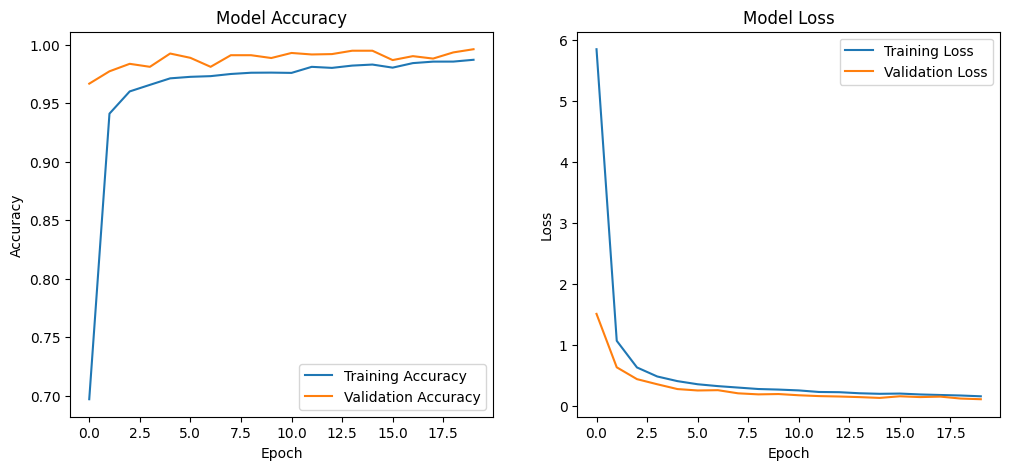

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       400
     Class 1       1.00      0.99      0.99       407
     Class 2       1.00      1.00      1.00       647
     Class 3       0.99      1.00      1.00       551
     Class 4       1.00      1.00      1.00      1042
     Class 5       1.00      0.99      0.99      1081
     Class 6       0.99      1.00      1.00      2130

    accuracy                           0.99      6258
   macro avg       1.00      0.99      0.99      6258
weighted avg       0.99      0.99      0.99      6258



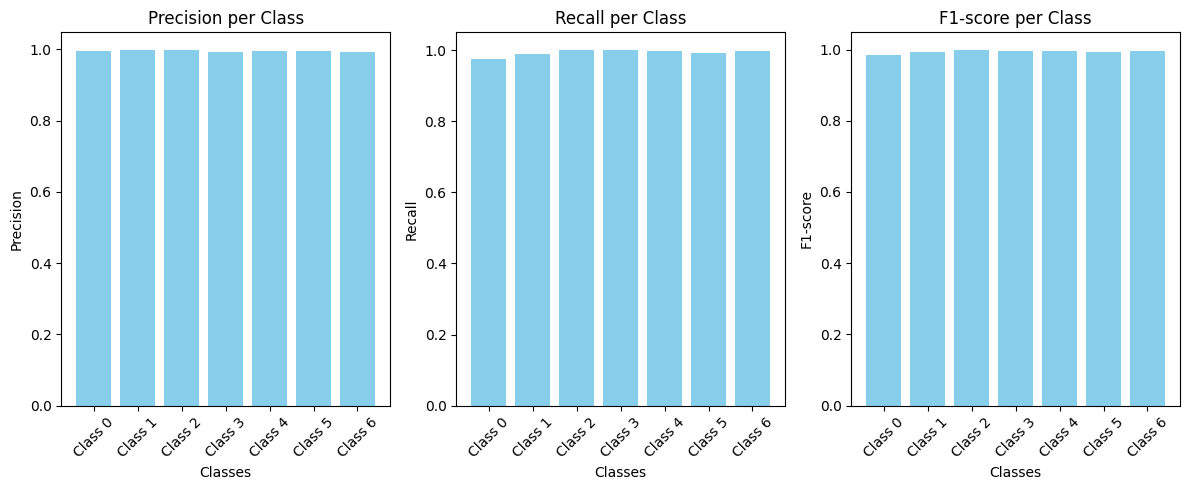

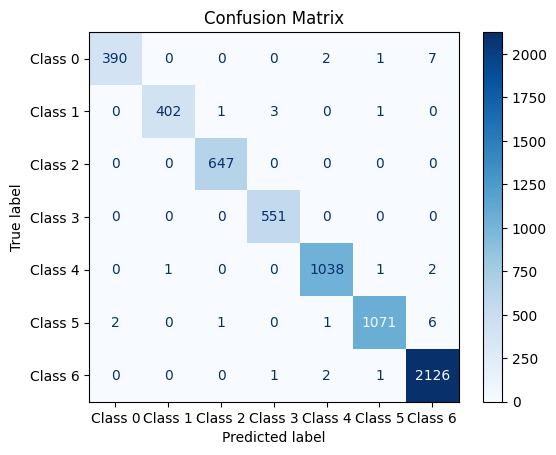

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 학습 및 검증 정확도, 손실 시각화
def plot_training_history(history):
    # 정확도 그래프
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 성능 그래프 출력
plot_training_history(history)

# 테스트 데이터셋 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 분류 보고서
report = classification_report(y_test_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(7)], output_dict=True)
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(7)]))

# F1 Score, Precision, Recall 시각화
metrics = ["precision", "recall", "f1-score"]
classes = [f"Class {i}" for i in range(7)]

plt.figure(figsize=(12, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    values = [report[cls][metric] for cls in classes]
    plt.bar(classes, values, color='skyblue')
    plt.title(f"{metric.capitalize()} per Class")
    plt.xlabel('Classes')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 혼동 행렬
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(7)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [3]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from collections import deque
import time
from PIL import Image, ImageDraw, ImageFont


class PoseClassifier:
    def __init__(self, model_path, class_names, sequence_length=16):
        self.model = load_model(model_path)
        self.class_names = class_names
        self.sequence_length = sequence_length
        self.sequence = deque(maxlen=self.sequence_length)
        self.state = 'idle'
        self.last_class_name = ""
        self.last_movement_time = time.time()
        self.last_prediction_time = time.time()

        # Mediapipe 초기화
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.7)
        self.mp_drawing = mp.solutions.drawing_utils

    def extract_landmarks(self, results, image_width, image_height):
        """
        Mediapipe 결과에서 24개의 랜드마크 좌표를 추출하고, 엉덩이 중앙을 기준으로 상대좌표로 변환 후 보정
        """
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            extracted_landmarks = []

            # Mediapipe 랜드마크 매핑 (사용자 정의 순서에 맞게 재배치)
            mediapipe_mapping = {
                'Nose': self.mp_pose.PoseLandmark.NOSE,
                'Left Eye': self.mp_pose.PoseLandmark.LEFT_EYE,
                'Right Eye': self.mp_pose.PoseLandmark.RIGHT_EYE,
                'Left Ear': self.mp_pose.PoseLandmark.LEFT_EAR,
                'Right Ear': self.mp_pose.PoseLandmark.RIGHT_EAR,
                'Left Shoulder': self.mp_pose.PoseLandmark.LEFT_SHOULDER,
                'Right Shoulder': self.mp_pose.PoseLandmark.RIGHT_SHOULDER,
                'Left Elbow': self.mp_pose.PoseLandmark.LEFT_ELBOW,
                'Right Elbow': self.mp_pose.PoseLandmark.RIGHT_ELBOW,
                'Left Wrist': self.mp_pose.PoseLandmark.LEFT_WRIST,
                'Right Wrist': self.mp_pose.PoseLandmark.RIGHT_WRIST,
                'Left Hip': self.mp_pose.PoseLandmark.LEFT_HIP,
                'Right Hip': self.mp_pose.PoseLandmark.RIGHT_HIP,
                'Left Knee': self.mp_pose.PoseLandmark.LEFT_KNEE,
                'Right Knee': self.mp_pose.PoseLandmark.RIGHT_KNEE,
                'Left Ankle': self.mp_pose.PoseLandmark.LEFT_ANKLE,
                'Right Ankle': self.mp_pose.PoseLandmark.RIGHT_ANKLE,
                'Neck': None,  # Neck은 계산 후 추가
                'Left Palm': self.mp_pose.PoseLandmark.LEFT_INDEX,
                'Right Palm': self.mp_pose.PoseLandmark.RIGHT_INDEX,
                'Back': None,  # Back은 계산 후 추가
                'Waist': None,  # Waist는 계산 후 추가
                'Left Foot': self.mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
                'Right Foot': self.mp_pose.PoseLandmark.RIGHT_FOOT_INDEX,
            }

            # Hip Center 계산
            left_hip = landmarks[self.mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = landmarks[self.mp_pose.PoseLandmark.RIGHT_HIP]
            hip_x = (left_hip.x + right_hip.x) / 2
            hip_y = (left_hip.y + right_hip.y) / 2

            # Waist 계산 (기준점)
            waist_x = hip_x
            waist_y = hip_y

            # Shoulder Center 계산
            left_shoulder = landmarks[self.mp_pose.PoseLandmark.LEFT_SHOULDER]
            right_shoulder = landmarks[self.mp_pose.PoseLandmark.RIGHT_SHOULDER]
            shoulder_center_x = (left_shoulder.x + right_shoulder.x) / 2
            shoulder_center_y = (left_shoulder.y + right_shoulder.y) / 2

            # Neck 계산
            nose = landmarks[self.mp_pose.PoseLandmark.NOSE]
            neck_x = (shoulder_center_x + nose.x) / 2
            neck_y = (shoulder_center_y + nose.y) / 2

            # Back 계산 (어깨 중심과 Waist의 중간)
            back_x = (shoulder_center_x + waist_x) / 2
            back_y = (shoulder_center_y + waist_y) / 2

            # 유효한 랜드마크 좌표 추출
            for name, mp_index in mediapipe_mapping.items():
                if name in ['Neck', 'Back', 'Waist']:
                    # Neck, Back, Waist는 계산 후 추가
                    if name == 'Neck':
                        pixel_x = int(neck_x * image_width)
                        pixel_y = int(neck_y * image_height)
                    elif name == 'Back':
                        pixel_x = int(back_x * image_width)
                        pixel_y = int(back_y * image_height)
                    elif name == 'Waist':
                        pixel_x = int(waist_x * image_width)
                        pixel_y = int(waist_y * image_height)
                        extracted_landmarks.append([0, 0])  # Waist는 기준점
                        continue
                    relative_x = pixel_x - (waist_x * image_width)
                    relative_y = pixel_y - (waist_y * image_height)
                    extracted_landmarks.append([relative_x, relative_y])
                else:
                    # Mediapipe 랜드마크 추출
                    landmark = landmarks[mp_index]
                    if landmark.visibility > 0.5:
                        pixel_x = int(landmark.x * image_width)
                        pixel_y = int(landmark.y * image_height)
                        relative_x = pixel_x - (waist_x * image_width)
                        relative_y = pixel_y - (waist_y * image_height)
                        extracted_landmarks.append([relative_x, relative_y])
                    else:
                        extracted_landmarks.append([0, 0])  # 감지되지 않은 랜드마크는 기본값

            return np.array(extracted_landmarks)
        return None


    def detect_movement(self):
        if len(self.sequence) < 2:
            return False
        prev_frame = np.array(self.sequence[-2])
        curr_frame = np.array(self.sequence[-1])
        movement = np.linalg.norm(curr_frame - prev_frame, axis=1).mean()
        return movement > 0

    def predict_class(self):
        # 입력 데이터 형태 확인
        input_data = np.array(self.sequence).reshape(1, self.sequence_length, 24, 2)
        print(f"Input data shape: {input_data.shape}")
        
        # 모델 예측 수행
        prediction = self.model.predict(input_data)
        print(f"Raw prediction output: {prediction}")
        
        # 예측 클래스 결정
        predicted_class = np.argmax(prediction)
        print(f"Predicted class index: {predicted_class}")
        
        # 클래스 이름 저장
        self.last_class_name = self.class_names[predicted_class]
        print(f"Predicted class name: {self.last_class_name}")


    def process_frame(self, frame):
        image_height, image_width, _ = frame.shape
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.pose.process(image)

        landmarks = self.extract_landmarks(results, image_width, image_height)
        if landmarks is not None:
            # 프레임 수집: 16프레임 유지
            self.sequence.append(landmarks)

            # 움직임 감지
            if self.detect_movement():
                self.last_movement_time = time.time()
                if self.state == 'idle':
                    self.state = 'active'

        # 상태 전환
        if self.state == 'active' and time.time() - self.last_movement_time > 5:
            self.state = 'idle'
            self.last_class_name = ""

        # 예측: 2~3초마다 실행
        if self.state == 'active' and len(self.sequence) == self.sequence_length:
            current_time = time.time()
            if current_time - self.last_prediction_time > 3:  # 2초마다 예측
                self.predict_class()
                self.last_prediction_time = current_time

        return results


    def draw_results(self, frame, results):
        # OpenCV 이미지를 Pillow 이미지로 변환
        image_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(image_pil)

        # Ubuntu 글씨체 설정
        font_path = "/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf"  # 기본 Ubuntu 글씨체
        font = ImageFont.truetype(font_path, 32)

        # 텍스트 추가
        if self.last_class_name:
            draw.text((10, 50), f"Class: {self.last_class_name}", font=font, fill=(0, 255, 0))
        draw.text((10, 100), f"State: {self.state}", font=font, fill=(255, 0, 0))

        # Mediapipe 랜드마크 그리기
        frame = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        if results.pose_landmarks:
            self.mp_drawing.draw_landmarks(frame, results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS)

        return frame

    def release_resources(self):
        self.pose.close()


class PoseApp:
    def __init__(self, model_path, class_names):
        self.classifier = PoseClassifier(model_path, class_names)

    def run(self):
        video_path = "../video/고1 풀업 자세맞나요？ [LIzOX_2rKos].webm"
        cap = cv2.VideoCapture(video_path)
        print("웹캠 시작... 종료하려면 'q'를 누르세요.")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, (353, 563))
            results = self.classifier.process_frame(frame)
            frame = self.classifier.draw_results(frame, results)

            cv2.imshow('Pose Classification', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        self.classifier.release_resources()


if __name__ == "__main__":
    MODEL_PATH = 'pose_classification_model_gru_v11.h5'
    CLASS_NAMES = ['Dips', 'Pullup', 'Pushup', 'Squat', 'Deadlift', 'Side Lateral Raise', 'Curl']

    app = PoseApp(MODEL_PATH, CLASS_NAMES)
    app.run()


I0000 00:00:1733901626.493687   38537 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733901626.494468   39572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1733901626.577014   39561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733901626.617261   39559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
QObject::moveToThread: Current thread (0x6429af0cb8b0) is not the object's thread (0x6429b0c429d0).
Cannot move to target thread (0x6429af0cb8b0)

QObject::moveToThread: Current thread (0x6429af0cb8b0) is not the object's thread (0x6429b0c429d0).
Cannot move to target thread (0x6429af0cb8b0)

QObject::moveToThread: Current thread (0x6429af0cb8b0) is not the

웹캠 시작... 종료하려면 'q'를 누르세요.
Input data shape: (1, 16, 24, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
Raw prediction output: [[3.5833807e-05 9.9807656e-01 1.0935263e-03 7.1170815e-04 2.3046613e-07
  7.8133686e-05 3.9590013e-06]]
Predicted class index: 1
Predicted class name: Pullup
Input data shape: (1, 16, 24, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Raw prediction output: [[3.6349946e-05 9.9804962e-01 1.1185927e-03 7.1147823e-04 2.3567414e-07
  7.9620477e-05 4.0061486e-06]]
Predicted class index: 1
Predicted class name: Pullup
Input data shape: (1, 16, 24, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Raw prediction output: [[3.5938730e-05 9.9807066e-01 1.0984457e-03 7.1232254e-04 2.3175633e-07
  7.8478915e-05 3.9737074e-06]]
Predicted class index: 1
Predicted class name: Pullup
Input data shape: (1, 16, 24, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Raw prediction output: [[3.5052013e-05 9.9335879e-01 1.8521782e-04 6.1463662e-03 2.0960735e-07
  2.5990146e-04 1.4421361e-05]]
Predicted class ind